# Importing packages and data

In [ ]:
# We use hmmlearn which has been created by Sergei Lebedev (software engineer at Deepmind)
# and is mantained by Antony Lee (who has a PhD in biophysics from UC Berkeley)
!pip install hmmlearn

     |████████████████████████████████| 368kB 7.7MB/s eta 0:00:01


In [ ]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
Colab = True
 
if Colab:
 
    !pip install -U -q PyDrive
    from pydrive.auth import GoogleAuth
    from pydrive.drive import GoogleDrive
    from google.colab import auth
    from oauth2client.client import GoogleCredentials
 
    # Authenticate and create the PyDrive client.
    # This only needs _ be done once per notebook.
    auth.authenticate_user()
    gauth = GoogleAuth()
    gauth.credentials = GoogleCredentials.get_application_default()
    drive = GoogleDrive(gauth)
 
    # Import MSCI ACWI
    file_id = '1AMkF3y_Qpx9_VN2sKa9Fp_wvrHqsf7d-'
    downloaded = drive.CreateFile({'id': file_id})
    downloaded.GetContentFile('Factor Index.xlsx')

In [ ]:
#suppressing warnings because of some issues with the font package
#in general, would not rec turning off warnings.
import warnings
warnings.filterwarnings("ignore")
 
#import packages for use later in the HMM code
from hmmlearn import hmm
import pandas as pd; pd.set_option('precision', 4)
import numpy as np; np.set_printoptions(precision=4, suppress=True)
from scipy import stats
import statsmodels.api as sm 
 
import datetime as dt
 
import matplotlib as mpl
from matplotlib import cm
import matplotlib.pyplot as plt
from matplotlib.dates import YearLocator, MonthLocator
import matplotlib.dates as mdates
fontsize = 15 # Set fontsize for all figures
plt.rc('font', size=fontsize)          # controls default text sizes
plt.rc('axes', titlesize=fontsize)     # fontsize of the axes title
plt.rc('axes', labelsize=fontsize)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=fontsize)    # fontsize of the tick labels
plt.rc('ytick', labelsize=fontsize)    # fontsize of the tick labels
plt.rc('legend', fontsize=fontsize)    # legend fontsize
plt.rc('figure', titlesize=fontsize)  # fontsize of the figure title
 
 
import seaborn as sns
#from pandas_datareader import data
 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, acf, pacf
import matplotlib.gridspec as gridspec
import matplotlib as mpl
from datetime import datetime
 
%matplotlib inline
 
def printf(text, value, pct=False):
    if pct == True:
        print(text, f"{value*100:.4f}%")
    else:
        print(text, f"{value:.4f}")

In [ ]:
#Load all factors into df_index then sort out the one to use in df.
df_index = pd.read_excel('Factor Index.xlsx', index_col = 'Date')
df_index.rename(columns = {'MSCI World Index, Total Return Index (Net Dividends)': 'MSCI ACWI'}, inplace = True)
df = df_index[['MSCI ACWI']]
df.sort_index(ascending = True, inplace = True)
df['log returns'] = np.log(df['MSCI ACWI']) - np.log(df['MSCI ACWI'].shift(1))
df.dropna(inplace=True)
df.head()

,MSCI ACWI,log returns
Date,,
1970-01-07,100.67,0.0067
1970-01-14,99.77,-0.0090
1970-01-21,98.38,-0.0140
1970-01-28,95.91,-0.0254
1970-01-30,94.25,-0.0175


In [ ]:
# StandardScale all x-variables - improves performance and robustness of fitted models
from sklearn.preprocessing import StandardScaler

# All subsets need their own scaler in order to call the inverse_transform method
scaler_train = StandardScaler()
scaler_test = StandardScaler()
scaler_all = StandardScaler()


# Set train and test periods
start_train = '1990-01-07'
end_train = '2015-01-01'

start_test = '2015-01-02'
end_test = '2020-05-19'

# Get train and test as datetimes - used for plotting
start_train_dt = datetime.strptime(start_train, '%Y-%m-%d')
end_train_dt = datetime.strptime(end_train, '%Y-%m-%d')
start_test_dt = datetime.strptime(start_test, '%Y-%m-%d')
end_test_dt = datetime.strptime(end_test, '%Y-%m-%d')

df = df.loc[start_train:end_test]

#Get train & test sets - keep as Dataframe as oppossed to pandas series.
x_train = pd.DataFrame(df.loc[start_train:end_train, 'log returns'])
x_test = pd.DataFrame(df.loc[start_test:end_test, 'log returns'])
x_all = pd.DataFrame(df.loc[start_train:end_test, 'log returns'])

# Scale train & test sets
x_train_scaled = pd.DataFrame(scaler_train.fit_transform(x_train),
             columns = ["log returns"],
             index=x_train.index)

x_test_scaled = pd.DataFrame(scaler_test.fit_transform(x_test ),
             columns = ["log returns"],
             index=x_test.index)

x_all_scaled = pd.DataFrame(scaler_all.fit_transform(x_all),
             columns = ["log returns"],
             index=x_all.index)

#Set variable for index prices and set index 100 to first obs - only used for plotting
prices = df.loc[start_train:end_test , 'MSCI ACWI']
prices = df.loc[:,"MSCI ACWI"] / df.iloc[0]["MSCI ACWI"] * 100

# Data Exploration

## Input time series

We look at statistical properties of the returns series that we use as an input for the HMM.

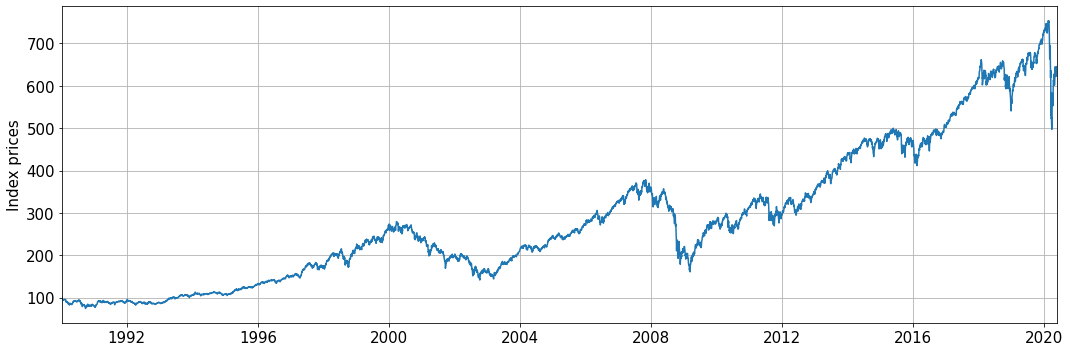

In [ ]:
def plot_test_area(ax):
    # Set grey background for in-sample data
    ax.axvspan(start_train_dt, end_train_dt, alpha=0.5, color='white')
    ax.axvspan(start_test_dt, end_test_dt, alpha=0.5, color='grey', label = "Out of sample")
    


fig, ax = plt.subplots(figsize=(15,5))

plt.plot(prices)
plt.ylabel('Index prices')

plt.xlim(start_train_dt ,end_test_dt)
plt.grid()
plt.tight_layout()
plt.savefig("MSCI ACWI")

In [ ]:
# Summary statistics of train and test data
printf("Train/Total OBS ratio = ", len(x_train)/(len(x_test)+len(x_train)) , pct=True )

for data,sample in zip([x_train, x_test],["In-sample", "Out of sample"]):
    print("-"*40)
    print(sample,"\n")
    display(pd.DataFrame(data.describe(include = 'all')).T.round(4))

    printf("Skewness = ", stats.skew(data.round(4))[0])
    printf("Excess Kurtosis = ", stats.kurtosis(data)[0])

Train/Total OBS ratio =  82.2898%
----------------------------------------
In-sample 



,count,mean,std,min,25%,50%,75%,max
log returns,6519.0,0.0002,0.0094,-0.0732,-0.004,0.0006,0.0048,0.091


Skewness =  -0.3328
Excess Kurtosis =  8.1738
----------------------------------------
Out of sample 



,count,mean,std,min,25%,50%,75%,max
log returns,1403.0,0.0002,0.0098,-0.1042,-0.0028,0.0005,0.0042,0.0842


Skewness =  -1.5529
Excess Kurtosis =  26.3055


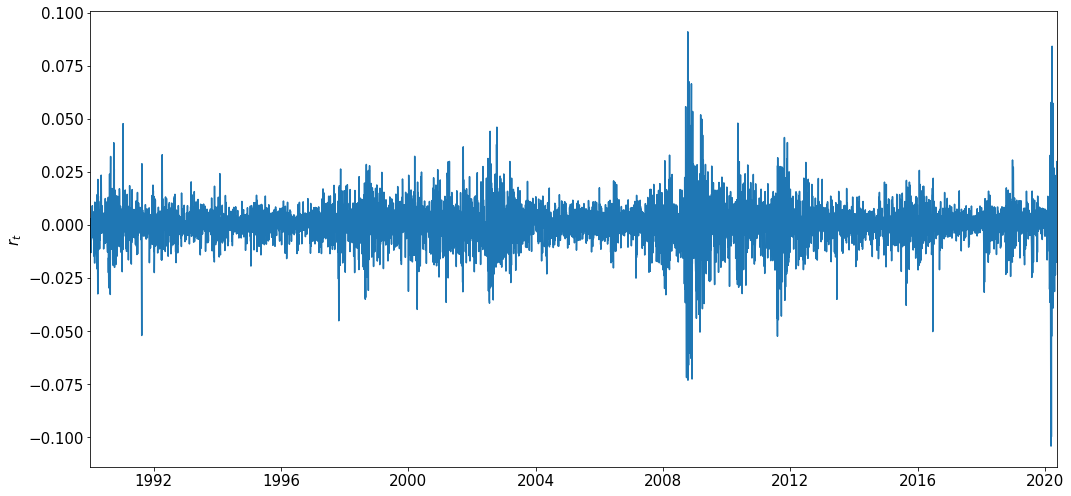

In [ ]:
# Create a 2x2 grid to plot in:
fig, ax1 = plt.subplots(figsize=(15,7))

#Plot log returns
ax1.plot(x_all)

ax1.set_ylabel('$r_t$')
plt.xlim(start_train_dt, end_test_dt)
plt.tight_layout()
plt.savefig("Log returns")

## In-sample data distribution - Add legend

NameError: ignored

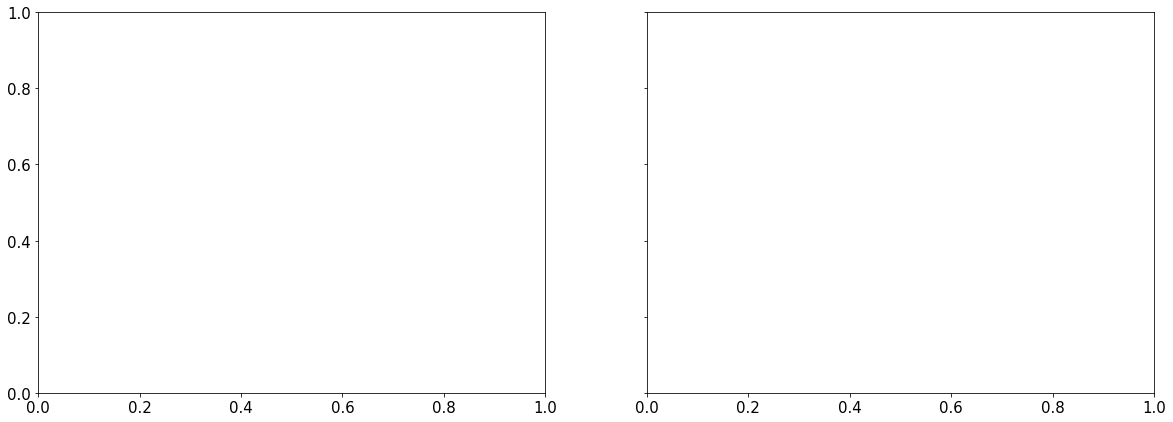

In [ ]:

### PLOTTING DISTRIBUTION
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,figsize=(20,7), sharey = True)
plt.subplots_adjust(wspace = 0.2, hspace=0.5)

for i,(ax, samplex) in enumerate(zip([ax1, ax2], [np.array(sample_list1), np.array(sample_list2)]) ):
    
    ax.hist(df["log returns"], bins=100, density=True, color="g", alpha=0.2, label="$r_t$")
    sns.distplot(samplex, ax=ax, rug = False, hist=False,
                     kde = True, label="Unconditional HMM distribution", color="b")
    
    ax.plot(x, stats.norm.pdf(x, loc=df["log returns"].mean(), scale =df["log returns"].std() ),
             label="Fitted Normal distribution", color="r")
    
    ax.set_title("{}-state HMM".format(i+2))
    ax.set_xlim(left=-0.075, right=0.075)
    ax.legend(fontsize=10)

In [ ]:
x = np.linspace(-0.05, 0.05, 1000)
# Plot distribution
fig, ax = plt.subplots(figsize=(15,7))

plt.hist(df["log returns"], bins=100, density=True, color="g", alpha=0.2, label="$r_t$")
plt.plot(x, stats.norm.pdf(x, loc=df["log returns"].mean(), scale =df["log returns"].std() ),
             label="Fitted Normal distribution", color="r")

plt.xlim(-0.05, 0.05)
plt.tight_layout()
plt.legend()
plt.savefig("Distribution")

# ACF - Fi autocorrelations - should be constant

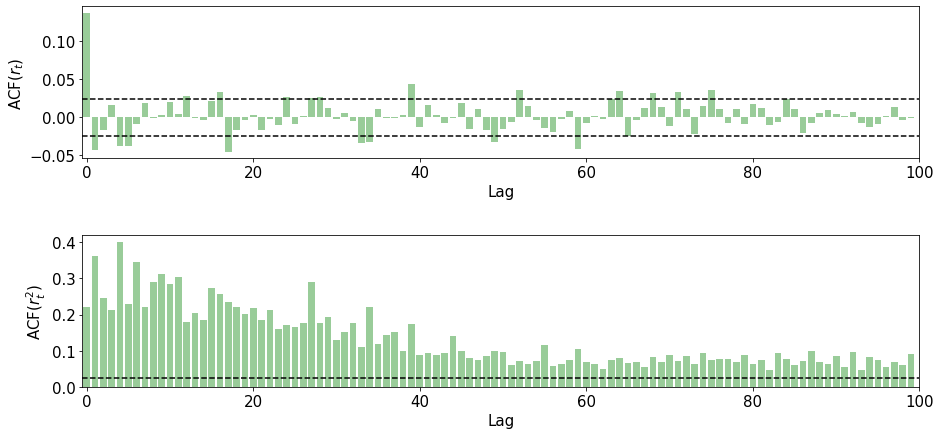

In [ ]:
#### Compute ACF and ACF^2 for training set
n_lags = 100
lags = [i for i in range(n_lags)]
acf = sm.tsa.acf(x_train, nlags=n_lags)[1:]
acf_squared = sm.tsa.acf(x_train**2, nlags=n_lags)[1:]

acf_conf = [1.96 / np.sqrt(len(x_train)), -1.96 / np.sqrt(len(x_train))]
acf_squared_conf = [1.96 / np.sqrt(len(x_train**2)), -1.96 / np.sqrt(len(x_train**2))]

# Create a 2x1 grid to plot in:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(15,7))
plt.subplots_adjust(wspace = 0.2, hspace=0.5)

#Plot ACF & PACF
labels = ["ACF($r_t)$","ACF($r^2_t$)"]
variables = [acf, acf_squared]
confidence = [acf_conf, acf_squared_conf]
for (ax, var, conf, label) in zip([ax1, ax2], variables, confidence,labels):
    ax.bar(lags, var, color="g", alpha=0.4)
    ax.axhline(conf[0], linestyle = 'dashed', color = 'black')
    ax.axhline(conf[1], linestyle = 'dashed', color = 'black')
    ax.set_ylabel(label)
    ax.set_xlabel("Lag")
    ax.set_xlim(left=-0.5, right = max(lags)+1)
    
ax2.set_ylim(bottom=0)
plt.savefig("ACF")

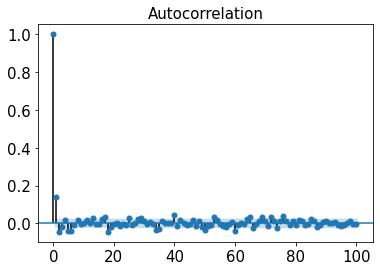

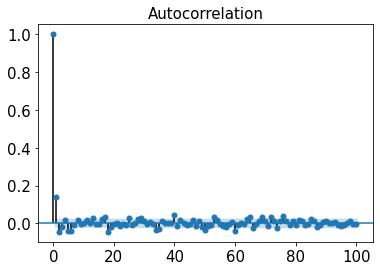

In [ ]:
plot_acf(x_train, lags=100)

# 2-state HMM -Rolling estimation

In [ ]:
n_samples =  2
 
acf_list1 = []
sample_list1 = []
 
means_0 = []
means_1 = []
 
var_0 = []
var_1 = []
 
state_list = []
trans_0_list = []
trans_1_list = []
 
prob1_list = []
prob2_list = []
 
convergence = []
 
for i in range(1, len(df) - 2499):
 
    # Rolling window of 2300 days
    X_rolling = x_all_scaled.iloc[i: 2500 + i]
    
    model = hmm.GaussianHMM(n_components=2, 
                            covariance_type="full",
                            n_iter = 1000).fit(X_rolling)
 
    df_data = pd.DataFrame(np.c_[model.means_, np.vstack(model.covars_), np.vstack(np.diag(model.transmat_)),
                                model.predict_proba(X_rolling)[-1]],
                           columns = ['Means', 'Variances', 'Transition probabilities', "Prob"])
    df_data.sort_values(by = 'Variances', ascending = True, inplace = True)
    
    #Inverse transform means to match log returns
    df_data["Means"] = scaler_all.inverse_transform(df_data[["Means"]])
    
    
    # Logic is: The good state is 0. If the first state is not the good state, we need to reverse the prediction.
    if df_data["Variances"].iloc[0] == np.vstack(model.covars_)[0][0]:
        current_state = model.predict(X_rolling)[-1]
    else:
        if model.predict(X_rolling)[-1] == 0:
            current_state = 1
        elif model.predict(X_rolling)[-1] == 1:
            current_state = 0
 
    state_list.append(current_state)
    
    means_0.append(df_data['Means'].iloc[0])
    means_1.append(df_data['Means'].iloc[1])
 
    var_0.append(df_data['Variances'].iloc[0])
    var_1.append(df_data['Variances'].iloc[1])
 
    trans_0_list.append(df_data['Transition probabilities'].iloc[0])
    trans_1_list.append(df_data['Transition probabilities'].iloc[1])
    
    prob1_list.append(df_data["Prob"].iloc[0] )
    prob2_list.append( df_data["Prob"].iloc[1] )
 
    convergence.append(model.monitor_.converged)
    
    # Sample from the model, inverse scale it and compute ACF^2
    #sample = np.vstack(scaler_train.inverse_transform(model.sample(n_samples)[0]))
    #acf_squared1 = sm.tsa.acf(sample**2, nlags= n_lags)[1:]
 
    #acf_list1.append(acf_squared1)
    #sample_list1.append(sample)
    
    if i % 5 == 0:  
        print("{}% complete at {}".format(round(100*i / (len(df) - 2499), ndigits=2 ), datetime.now().strftime("%H:%M:%S")))
        
acf1_squared_mean = np.mean(acf_list1, axis=0)
print("No. of models that did not converge: ", len(means_0) - np.sum(convergence))

0.09% complete at 12:30:17
0.18% complete at 12:30:18
0.28% complete at 12:30:20
0.37% complete at 12:30:21
0.46% complete at 12:30:23
0.55% complete at 12:30:24
0.65% complete at 12:30:26
0.74% complete at 12:30:27
0.83% complete at 12:30:29
0.92% complete at 12:30:30
1.01% complete at 12:30:32
1.11% complete at 12:30:33
1.2% complete at 12:30:35
1.29% complete at 12:30:37
1.38% complete at 12:30:38
1.48% complete at 12:30:40
1.57% complete at 12:30:41
1.66% complete at 12:30:43
1.75% complete at 12:30:44
1.84% complete at 12:30:46
1.94% complete at 12:30:47
2.03% complete at 12:30:49
2.12% complete at 12:30:50
2.21% complete at 12:30:52
2.3% complete at 12:30:53
2.4% complete at 12:30:55
2.49% complete at 12:30:56
2.58% complete at 12:30:58
2.67% complete at 12:30:59
2.77% complete at 12:31:01
2.86% complete at 12:31:02
2.95% complete at 12:31:04
3.04% complete at 12:31:05
3.13% complete at 12:31:07
3.23% complete at 12:31:09
3.32% complete at 12:31:10
3.41% complete at 12:31:12
3.5%

In [ ]:
df_rolling = pd.DataFrame(data = {"states":state_list,
                     "Posterior prob 1":prob1_list,
                     "Posterior prob 2":prob2_list},
            index = df[2500:].index)
df_rolling.head(2)

,states,Posterior prob 1,Posterior prob 2
Date,,,
1999-08-09,0,0.8341,0.1659
1999-08-10,0,0.5230,0.4770


## 2-state HMM static estimation IN-Sample

In [ ]:
# Loop through untill the static states has the right order
state_order = True
while state_order == True:
    # Train an N-state HMM model on training set
    num_states = 2
    model = hmm.GaussianHMM(n_components=num_states, 
                            covariance_type="full",
                            algorithm="viterbi",
                            n_iter = 1000).fit(x_all_scaled)


    static_mean = model.means_
    static_var = model.covars_
    static_transmat = model.transmat_

    if static_mean[0][0] == static_mean.max():
        print("Check model convergence:", model.monitor_.iter < 1000)

        print("\nA = Transition matrix in % (Gamma):")
        display(pd.DataFrame(data = static_transmat*100).round(4))
        
        display(pd.DataFrame(data={"$\pi$ (%)":model.startprob_*100,
                       "$\delta$ (%)": model.get_stationary_distribution() * 100,
                       "$\mu*10^4$": [x for x in static_mean], # Annoying way of remving extra dimension in means_
                       "$\sigma^2*10^4$":[x for x in static_var] 
                                   }).round(4) )
        break
        
        

Check model convergence: True

A = Transition matrix in % (Gamma):


,0,1
0,98.4399,1.5601
1,4.0747,95.9253


,$\pi$ (%),$\delta$ (%),$\mu*10^4$,$\sigma^2*10^4$
0,100.0,72.313,[0.04630501180522544],[[0.3546417025874265]]
1,0.0,27.687,[-0.12214150876645564],[[2.681735185884649]]


# 2-state  Plot rolling params - Fix X-axes, fix Y-axes and don't scale by 10**4

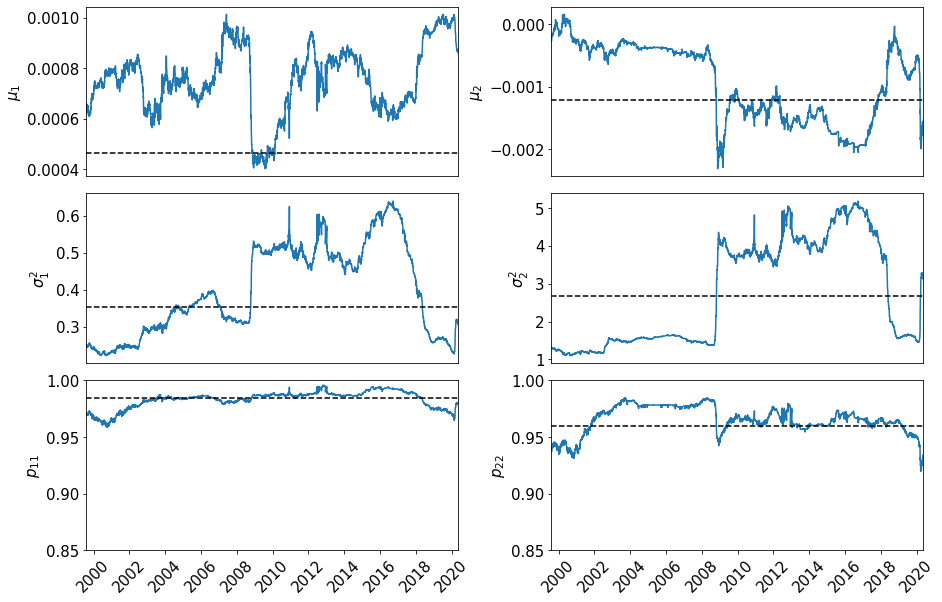

In [ ]:
# Create a 2x2 grid to plot in:
fig, ax = plt.subplots(2,2, figsize=(15,10), sharex = True)
plt.subplots_adjust(wspace = 0.25, hspace=0.1)

ax1 = plt.subplot2grid((3,2), (0,0))
ax2 = plt.subplot2grid((3,2), (0,1))
ax3 = plt.subplot2grid((3,2), (1,0))
ax4 = plt.subplot2grid((3,2), (1,1))
ax5 = plt.subplot2grid((3,2), (2,0))
ax6 = plt.subplot2grid((3,2), (2,1))

means_0_ = np.array(means_0)
means_1_ = np.array(means_1)

var_0 = np.array(var_0)
var_1 = np.array(var_1)

#Plotting
axes = [ax1, ax2, ax3, ax4, ax5, ax6]
variables = [means_0_, means_1_, var_0, var_1, trans_0_list, trans_1_list]
symbol_list = ['$\mu_1$', '$\mu_2$',
               '$\sigma^2_1$','$\sigma^2_2$',
               "$p_{11}$", "$p_{22}$"]

static_var = [static_mean[0] / 100, static_mean[1] / 100,
              static_var[0], static_var[1],
             static_transmat[0,0], static_transmat[1,1]  ]

x_axis = df_rolling.index

for (ax,var,static_var, symbol) in zip(axes, variables, static_var, symbol_list):
    ax.plot(x_axis, var)
    ax.set_ylabel(symbol, size=15)
    ax.set_xlim(df_rolling.index[0], end_test_dt)
    ax.tick_params('x', labelrotation=45)
    ax.axhline(y = static_var, ls="--", color = "black")
    ax.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False) # labels along the bottom edge are off

    if ax == ax5 or ax == ax6:
        ax.tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom = True,      # ticks along the bottom edge are on
            top = False,         # ticks along the top edge are off
            labelbottom = True) # labels along the bottom edge are on

    if symbol == "$p_{11}$" or symbol == "$p_{22}$":
        ax.set_ylim(bottom=0.85, top = 1.0)

plt.savefig("2-state HMM rolling params")

# 2-state Merge In-sample & Out-of-Sample predictions

In [60]:
df_merged = df_rolling.copy()

df_merged[ ["MSCI ACWI", "log returns"] ] = \
                                        df.loc[df_rolling.index[0]:end_test][["MSCI ACWI", "log returns"]]

df_merged.head()

,states,Posterior prob 1,Posterior prob 2,MSCI ACWI,log returns
Date,,,,,
1999-08-09,0,0.8341,0.1659,1309.1769,-0.0023
1999-08-10,0,0.5230,0.4770,1295.8741,-0.0102
1999-08-11,0,0.5697,0.4303,1305.2347,0.0072
1999-08-12,0,0.6526,0.3474,1313.6079,0.0064
1999-08-13,1,0.1074,0.8926,1332.7517,0.0145


# Make sure predictions are color coded right

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


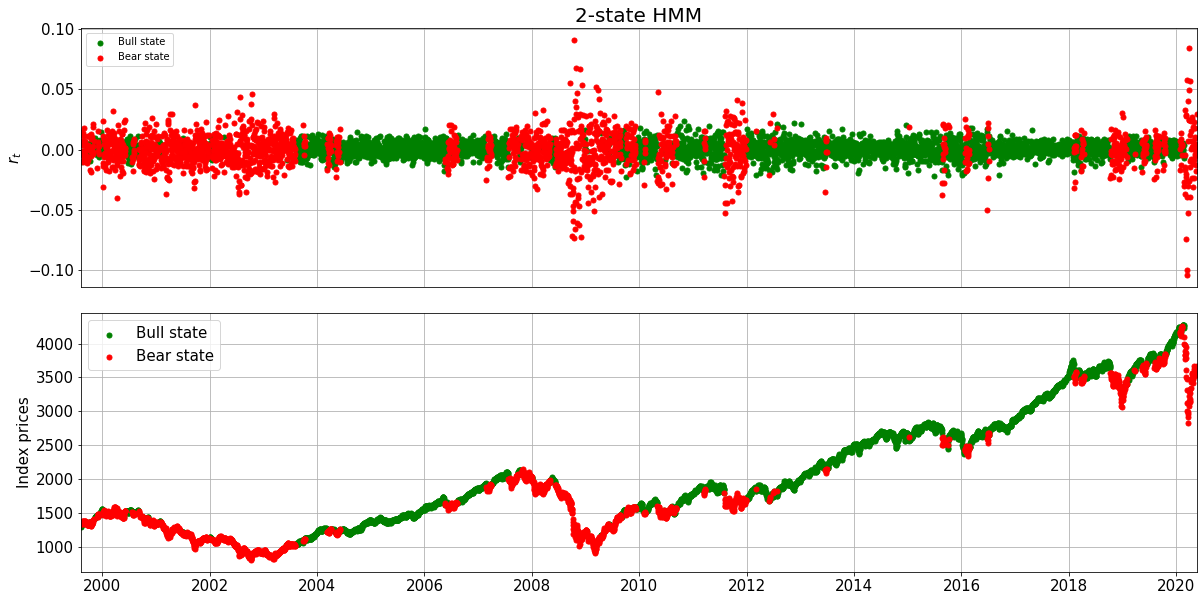

In [64]:
figsize = (20,10)

# 2X1 Grid
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize )
plt.subplots_adjust(wspace = 0.25, hspace=0.1)

colors = ["green", "red"] #"purple"]
variables = ["log returns", "MSCI ACWI"]
ylabels = ["$r_t$", "Index prices"]

for (ax, var, ylabel) in zip([ax1,ax2], variables, ylabels):
    
    n_states = max(df_merged["states"].unique()+1) # Number of states in current iteration
    if n_states == 2: labels = ["Bull state", "Bear state"]
    elif n_states == 3: labels = ["Bull state", "Bear state", "Recession state"]
    
    for state,color,label in zip(df_merged["states"].unique(), colors, labels ):
        plot_area = df_merged[df_merged["states"] == state]
        ax.scatter(plot_area.index , plot_area[var],
                    label=label, color=color,
                    s = 25,
                   zorder = 2)

    ax1.tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=False) # labels along the bottom edge are off
    ax1.set_title("2-state HMM", fontdict = {'family' : 'normal', 'weight' : 'normal', 'fontsize': 20})
    ax.set_xlim(df_merged.index[0], end_test_dt )
    ax.set_ylabel(ylabel)
    if ax == ax1: ax.legend(fontsize=10)
    else: ax.legend()
    ax.grid(True, ls="-")

plt.savefig("2-state ts")

# 2-state Probability Smoothing

In [ ]:
df_merged.head()

,states,Posterior prob 1,Posterior prob 2,MSCI ACWI,log returns
Date,,,,,
1999-08-09,0,0.8341,0.1659,1309.1769,-0.0023
1999-08-10,0,0.5230,0.4770,1295.8741,-0.0102
1999-08-11,0,0.5696,0.4304,1305.2347,0.0072
1999-08-12,0,0.6526,0.3474,1313.6079,0.0064
1999-08-13,1,0.1074,0.8926,1332.7517,0.0145


In [ ]:
# function to indicate if there is a transition
def transition_counter(x):
    # is a dataframe with two columns: (1) current state and (2) previous state for each period
    if x[0] == x[1]:
        return 0
    else:
        return 1


confidence_treshold = 0.92
            
df_merged["states_filtered"] = 5
df_merged["states_filtered"].iloc[0] = df_merged["states"].iloc[0]

for i in range(1,len(df_merged)):
    row = df_merged.iloc[i]
    
    last_pred = df_merged["states_filtered"].iloc[i-1]
    
    if row["states"] == last_pred:
        df_merged["states_filtered"].iloc[i] = row["states"]
    else:
        if row["states"] == 0:
            if row["Posterior prob 1"] > confidence_treshold:
                df_merged["states_filtered"].iloc[i] = 0
            else:
                df_merged["states_filtered"].iloc[i] = 1
        
        elif row["states"] == 1:
            if row["Posterior prob 2"] > confidence_treshold:
                df_merged["states_filtered"].iloc[i] = 1
            else:
                df_merged["states_filtered"].iloc[i] = 0

In [ ]:
df_merged['previous state'] = df_merged['states'].shift(1)
df_merged["previous state"].iloc[0] = df_merged["states"].iloc[0] #Otherwise first row is NaN

print("Number of transitions before smoothing = ", df_merged[['previous state', 'states']].apply(transition_counter, axis = 1).sum())

df_merged['previous state filtered'] = df_merged['states_filtered'].shift(1)
df_merged["previous state filtered"].iloc[0] = df_merged["states_filtered"].iloc[0] #Otherwise first row is NaN

print("Number of transitions after smoothing = ", df_merged[['previous state filtered', 'states_filtered']].apply(transition_counter, axis = 1).sum())

Number of transitions before smoothing =  209
Number of transitions after smoothing =  77


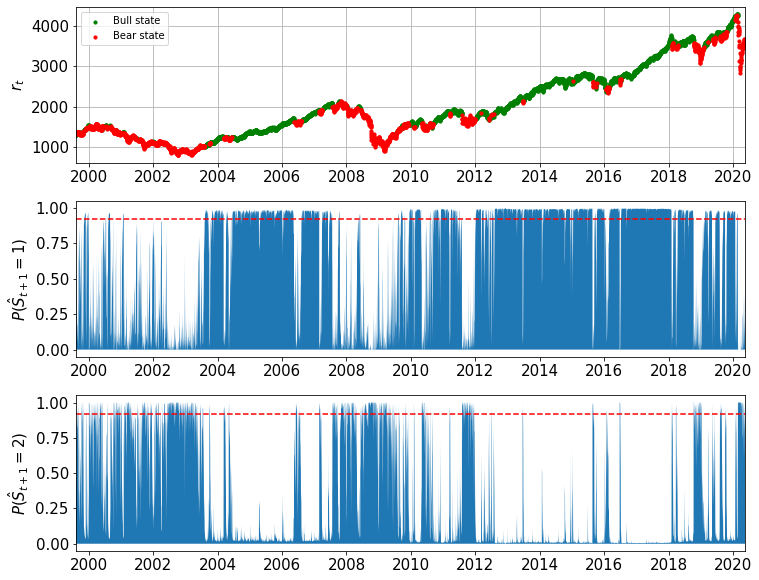

In [ ]:
# Create a 2x2 grid to plot in:
fig, (ax1, ax2,ax3) = plt.subplots(3,1, figsize=(12,10))
plt.subplots_adjust(wspace = 0.2, hspace=0.25)

n_states = max(df_merged["states"].unique()+1) # Number of states in current iteration
if n_states == 2: labels = ["Bull state", "Bear state"]
elif n_states == 3: labels = ["Bull state", "Bear state", "Recession state"]

for state,color, label in zip(df_merged["states"].unique(), colors, labels ):
    plot_area = df_merged[df_merged["states"] == state]
    ax1.scatter(plot_area.index , plot_area["MSCI ACWI"],
                label=label, color=color,
                s = 10,
               zorder = 2)

ax1.set_xlim(df_merged.index[0], df_merged.index[-1])
ax1.set_ylabel("$r_t$")
ax1.grid(True, ls="-")
ax1.legend(fontsize=10)


ax2.fill_between(df_merged.index, df_merged['Posterior prob 1'])
ax2.hlines(confidence_treshold, min(df_merged.index), max(df_merged.index), color = 'r', linestyles = '--')
ax2.set_ylabel("$P(\hat{S}_{t + 1} = 1)$", size=15)
ax2.set_xlim(df_merged.index[0], df_merged.index[-1])

ax3.fill_between(df_merged.index, df_merged['Posterior prob 2'])
ax3.hlines(confidence_treshold, min(df_merged.index), max(df_merged.index), color = 'r', linestyles = '--')
ax3.set_ylabel("$P(\hat{S}_{t + 1} = 2)$", size=15)
ax3.set_xlim(df_merged.index[0], df_merged.index[-1])

plt.savefig("2-state Prob_filter")

### Output to CSV

In [ ]:
df_merged[["states", "MSCI ACWI", "log returns"]].to_csv("2-state predictions.csv")

# 3-state HMM -Rolling estimation

In [ ]:
n_samples = 2

In [ ]:
means_0 = []
means_1 = []
means_2 = []

var_0 = []
var_1 = []
var_2 = []

state_list = []
trans_0_list = []
trans_1_list = []
trans_2_list = []

prob1_list = []
prob2_list = []
prob3_list = []

convergence = []

acf_list2 = []
sample_list2 = []

for i in range(1, len(df) - 2499):

    # Rolling window of 2300 days
    X_rolling = x_all_scaled.iloc[i: 2500 + i]
    
    model = hmm.GaussianHMM(n_components=3, 
                            covariance_type="full",
                            n_iter = 1000).fit(X_rolling)

    df_data = pd.DataFrame(np.c_[model.means_, np.vstack(model.covars_), np.vstack(np.diag(model.transmat_)),
                                model.predict_proba(X_rolling)[-1]],
                           columns = ['Means', 'Variances', 'Transition probabilities', "Prob"])

    #Inverse transform means to match log returns
    df_data["Means"] = scaler_all.inverse_transform(df_data[["Means"]])
    
    # Sort states
    df_data.sort_values(by = 'Means', ascending = False, inplace = True)
    df_data.sort_values(by = 'Variances', ascending = True, inplace = True)
    
    
    if df_data["Variances"].iloc[0] == np.vstack(model.covars_)[0][0]:
        ### IF the good state is first, nextbest is second
        ### Then 0=0, 1=1, 2=2
        if df_data["Variances"].iloc[1] == np.vstack(model.covars_)[1][0]:
            if model.predict(X_rolling)[-1] == 0:
                current_state = 0
            elif model.predict(X_rolling)[-1] == 1:
                current_state = 1
            elif model.predict(X_rolling)[-1] == 2:
                current_state = 2
        
        ### IF the good state is first, nextbest is third
        ### Then 0=0, 1=2, 2=1
        elif df_data["Variances"].iloc[1] == np.vstack(model.covars_)[2][0]:
            if model.predict(X_rolling)[-1] == 0:
                current_state = 0
            elif model.predict(X_rolling)[-1] == 1:
                current_state = 2
            elif model.predict(X_rolling)[-1] == 2:
                current_state = 1
        
    elif df_data["Variances"].iloc[0] == np.vstack(model.covars_)[1][0]:
        ### IF the good state is in the middle, and the nextbest state is in the top
        ### Then 0=1, 1=0, 2=2
        if df_data["Variances"].iloc[1] == np.vstack(model.covars_)[0][0]:
            if model.predict(X_rolling)[-1] == 0:
                current_state = 1
            elif model.predict(X_rolling)[-1] == 1:
                current_state = 0
            elif model.predict(X_rolling)[-1] == 2:
                current_state = 2
                      
        ### IF the good state is in the middle, and the nextbest state is in the bottom
        ### Then 0=2, 1=0, 2=1
        if df_data["Variances"].iloc[1] == np.vstack(model.covars_)[2][0]:
            if model.predict(X_rolling)[-1] == 0:
                current_state = 2
            elif model.predict(X_rolling)[-1] == 1:
                current_state = 0
            elif model.predict(X_rolling)[-1] == 2:
                current_state = 1
                
    elif df_data["Variances"].iloc[0] == np.vstack(model.covars_)[2][0]:
        ### IF the good state is in the bottom, and the nextbest state is in the top
        ### Then 0=1, 1=2, 2=0
        if df_data["Variances"].iloc[1] == np.vstack(model.covars_)[0][0]:
            if model.predict(X_rolling)[-1] == 0:
                current_state = 1
            elif model.predict(X_rolling)[-1] == 1:
                current_state = 2
            elif model.predict(X_rolling)[-1] == 2:
                current_state = 0
                      
        ### IF the good state is in the bottom, and the nextbest state is in the middle
        ### Then 0=2, 1=1, 2=0
        if df_data["Variances"].iloc[1] == np.vstack(model.covars_)[1][0]:
            if model.predict(X_rolling)[-1] == 0:
                current_state = 2
            elif model.predict(X_rolling)[-1] == 1:
                current_state = 1
            elif model.predict(X_rolling)[-1] == 2:
                current_state = 0
                
        
    state_list.append(current_state)
    
    means_0.append(df_data['Means'].iloc[0])
    means_1.append(df_data['Means'].iloc[1])
    means_2.append(df_data['Means'].iloc[2])

    var_0.append(df_data['Variances'].iloc[0])
    var_1.append(df_data['Variances'].iloc[1])
    var_2.append(df_data['Variances'].iloc[2])

    trans_0_list.append(df_data['Transition probabilities'].iloc[0])
    trans_1_list.append(df_data['Transition probabilities'].iloc[1])
    trans_2_list.append(df_data['Transition probabilities'].iloc[2])
    
    prob1_list.append(df_data["Prob"].iloc[0] )
    prob2_list.append( df_data["Prob"].iloc[1] )
    prob3_list.append( df_data["Prob"].iloc[2] )

    convergence.append(model.monitor_.converged)
    
    # Sample from the model, inverse scale it and compute ACF^2
    #sample = np.vstack(scaler_train.inverse_transform(model.sample(n_samples)[0]))
    #acf_squared2 = sm.tsa.acf(sample**2, nlags= n_lags)[1:]

    #acf_list2.append(acf_squared2)
    #sample_list2.append(sample)
    
    if i % 2 == 0:
        print("{}% complete".format(round(100*i / (len(df) - 2499), ndigits=2 )))

        
acf2_squared_mean = np.mean(acf_list2, axis=0)
print("No. of models that did not converge: ", len(means_0) - np.sum(convergence))

0.04% complete
0.07% complete
0.11% complete
0.15% complete
0.18% complete
0.22% complete
0.26% complete
0.3% complete
0.33% complete
0.37% complete
0.41% complete
0.44% complete
0.48% complete
0.52% complete
0.55% complete
0.59% complete
0.63% complete
0.66% complete
0.7% complete
0.74% complete
0.77% complete
0.81% complete
0.85% complete
0.89% complete
0.92% complete
0.96% complete
1.0% complete
1.03% complete
1.07% complete
1.11% complete
1.14% complete
1.18% complete
1.22% complete
1.25% complete
1.29% complete
1.33% complete
1.36% complete
1.4% complete
1.44% complete
1.48% complete
1.51% complete
1.55% complete
1.59% complete
1.62% complete
1.66% complete
1.7% complete
1.73% complete
1.77% complete
1.81% complete
1.84% complete
1.88% complete
1.92% complete
1.95% complete
1.99% complete
2.03% complete
2.07% complete
2.1% complete
2.14% complete
2.18% complete
2.21% complete
2.25% complete
2.29% complete
2.32% complete
2.36% complete
2.4% complete
2.43% complete
2.47% complete
2.

In [ ]:
df_rolling = pd.DataFrame(data = {"states":state_list,
                     "Posterior prob 1":prob1_list,
                     "Posterior prob 2":prob2_list,
                      "Posterior prob 3":prob3_list},
            index = df[2500:].index)
df_rolling.head(2)

,states,Posterior prob 1,Posterior prob 2,Posterior prob 3
Date,,,,
1999-08-09,0,0.7420,0.0868,0.1712
1999-08-10,0,0.3186,0.1077,0.5737


## Summary statistics and ACF

In [ ]:
mean_list = []
std_list = []
skewness_list = []
kurtosis_list = []

# Compute statistics for both models
for samplex in [sample_list1, sample_list2]:
    mean = np.mean(samplex)
    var = np.var(samplex, ddof=1)
    skew = stats.skew(samplex, axis=None)
    kurt = stats.kurtosis(samplex, axis=None)
    
    ## SAVE RESULTS
    mean_list.append(mean)
    std_list.append(np.sqrt(var))
    kurtosis_list.append(kurt)
    skewness_list.append(skew)

# Print results - Corresponds to MATCHING THE MOMENTS section in paper.
display(pd.DataFrame(np.vstack([mean_list, std_list, skewness_list, kurtosis_list]).T, 
                     index = ['2-state HMM', "3-state HMM"],
                     columns = ['Mean', 'Std', 'Skewness', 'Excess Kurtosis']).round(4) )

NameError: ignored

NameError: ignored

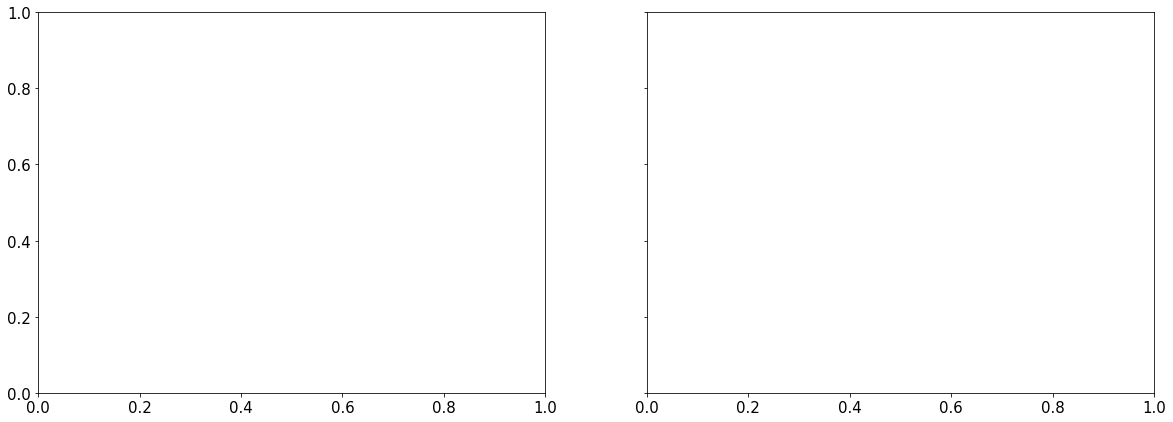

In [ ]:
### PLOTTING DISTRIBUTION

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,figsize=(20,7), sharey = True)
plt.subplots_adjust(wspace = 0.2, hspace=0.5)
x = np.linspace(-0.05, 0.05, 1000)

for i,(ax, samplex) in enumerate(zip([ax1, ax2], [np.array(sample_list1), np.array(sample_list2)]) ):
    
    ax.hist(df["log returns"], bins=100, density=True, color="g", alpha=0.2, label="$r_t$")
    sns.distplot(samplex, ax=ax, rug = False, hist=False,
                     kde = True, label="Unconditional HMM distribution", color="b")
    
    ax.plot(x, stats.norm.pdf(x, loc=df["log returns"].mean(), scale =df["log returns"].std() ),
             label="Fitted Normal distribution", color="r")
    
    ax.set_title("{}-state HMM".format(i+2))
    ax.set_xlim(left=-0.075, right=0.075)
    ax.legend(fontsize=10)
    
plt.savefig("HMM Distplot")

In [ ]:
n_lags = 100
acf_list = []
for i in range(np.shape(sample_list1)[1]):
    acf_list.append(sm.tsa.acf(np.array(sample_list1)[:, i]**2, nlags= n_lags)[1:])

    if i % 2 == 0:
        print("{}% complete at {}".format(round(100*i / np.shape(sample_list1)[1], ndigits=2 ), datetime.now().strftime("%H:%M:%S")))

acf_mean = np.mean(acf_list, axis = 0)

Streaming output truncated to the last 5000 lines.
7.82% complete at 08:11:11
7.86% complete at 08:11:12
7.89% complete at 08:11:12
7.93% complete at 08:11:13
7.97% complete at 08:11:13
8.0% complete at 08:11:14
8.04% complete at 08:11:14
8.08% complete at 08:11:15
8.11% complete at 08:11:15
8.15% complete at 08:11:16
8.19% complete at 08:11:16
8.22% complete at 08:11:17
8.26% complete at 08:11:17
8.3% complete at 08:11:18
8.33% complete at 08:11:18
8.37% complete at 08:11:19
8.41% complete at 08:11:19
8.45% complete at 08:11:20
8.48% complete at 08:11:20
8.52% complete at 08:11:21
8.56% complete at 08:11:21
8.59% complete at 08:11:22
8.63% complete at 08:11:22
8.67% complete at 08:11:23
8.7% complete at 08:11:23
8.74% complete at 08:11:24
8.78% complete at 08:11:24
8.81% complete at 08:11:25
8.85% complete at 08:11:25
8.89% complete at 08:11:26
8.92% complete at 08:11:26
8.96% complete at 08:11:27
9.0% complete at 08:11:27
9.04% complete at 08:11:28
9.07% complete at 08:11:28
9.11% co

KeyboardInterrupt: ignored

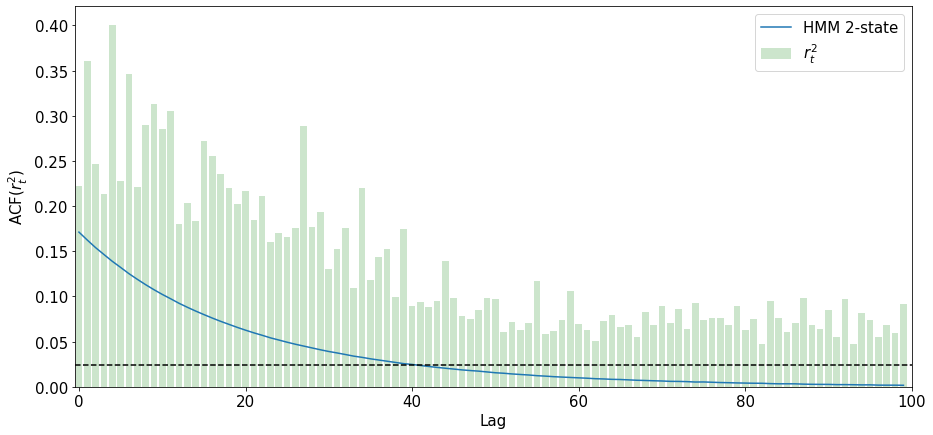

In [ ]:
#### PLOT ACF
n_lags = 100
acf_logret = sm.tsa.acf(x_train["log returns"]**2, nlags=n_lags)[1:]
acf_squared1 = sm.tsa.acf(sample_list1[0]**2, nlags= n_lags)[1:]
#acf_squared2 = sm.tsa.acf(df_sample2[0]**2, nlags= n_lags)[1:]
lags = [i for i in range(n_lags)]

fig, ax = plt.subplots( figsize=(15,7) )
plt.bar(lags, acf_logret, color="g", alpha=0.2, label="$r_t^2$")
plt.plot(lags, acf1_squared_mean, label="HMM 2-state")
#plt.plot(lags, acf2_squared_mean, label="HMM 3-state")
plt.axhline(conf[0], linestyle = 'dashed', color = 'black')
plt.axhline(conf[1], linestyle = 'dashed', color = 'black')


plt.legend()
plt.xlabel("Lag")
plt.ylabel("ACF($r_t^2$)")
plt.xlim(left=-0.5, right = max(lags)+1)
plt.ylim(bottom=0)

plt.savefig("HMM ACF")

In [ ]:
np.shape(sample_list1)

(5422, 25000, 1)

# Fix Y-axes and X-axes

In [ ]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

n = 50

ma_mean = moving_average(np.mean(sample_list1, axis=1), n = n)
ma_skew = moving_average(np.std(sample_list1, axis = 1, ddof=1), n = n)
ma_std = moving_average(stats.skew(sample_list1, axis=1), n = n)
ma_kurtosis = moving_average(stats.kurtosis(sample_list1, axis=1), n = n)

Loop done


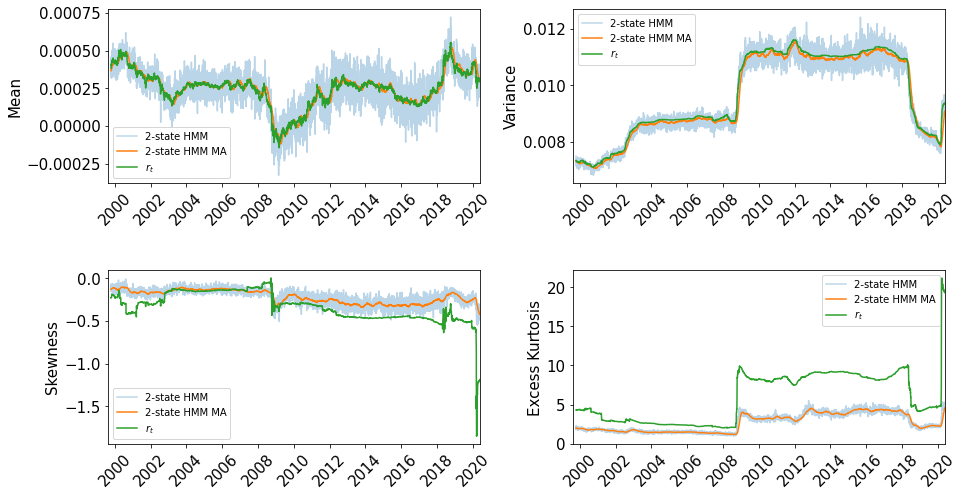

In [ ]:
log_ret = []
for i in range(1, len(df) - 2499):
     log_ret.append(df.iloc[i:2500 + i]["log returns"] )
print("Loop done")

            
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,8))
plt.subplots_adjust(wspace = 0.25, hspace=0.5)

ax1 = plt.subplot2grid((2,2), (0,0))
ax2 = plt.subplot2grid((2,2), (0,1))
ax3 = plt.subplot2grid((2,2), (1,0))
ax4 = plt.subplot2grid((2,2), (1,1))

x = range(len( stats.kurtosis(sample_list1, axis=1) ) )

axes = [ax1,ax2,ax3,ax4]
variables = [np.mean(sample_list1, axis=1), np.std(sample_list1, axis = 1, ddof=1),
            stats.skew(sample_list1, axis=1) ,stats.kurtosis(sample_list1, axis=1)]

log_ret_vars = [np.mean(log_ret, axis=1), np.std(log_ret, axis=1, ddof=1),
               stats.skew(log_ret, axis=1), stats.kurtosis(log_ret, axis=1)]

ma = [ma_mean, ma_skew, ma_std, ma_kurtosis]

symbols = ["Mean", "Variance", "Skewness", "Excess Kurtosis"]

for ax, var, logvar, symbol, moving_average in zip(axes, variables, log_ret_vars, symbols, ma):
    ax.plot(df_rolling.index[n-1:], var[n-1:], label = "2-state HMM", alpha = 0.3)
    ax.plot(df_rolling.index[n-1:], moving_average, label = "2-state HMM MA")
    ax.plot(df_rolling.index[n-1:], logvar[n-1:], label="$r_t$")
    ax.set_xlim(df_rolling.index[0], df_rolling.index[-1])
    ax.set_ylabel(symbol)
    ax.legend(fontsize=10)
    ax.tick_params('x', labelrotation=45)

plt.savefig("Matching_moments_ts")

## 3-state HMM static estimation IN-Sample

In [ ]:
# Train an N-state HMM model on training set
num_states = 3
model = hmm.GaussianHMM(n_components=num_states, 
                        covariance_type="full",
                        algorithm="viterbi",
                        n_iter = 1000).fit(x_all_scaled)


static_mean = scaler_all.inverse_transform(model.means_) * 10**4
static_var = np.vstack(model.covars_) * 10**4
static_transmat = model.transmat_

# Predict the optimal sequence of internal hidden state in training
# Note perfect foresight is assumed in training
y_train = model.predict(x_all_scaled)
y_placeholder = np.ones(len(x_test))*1000 # This variable will be deleted shortly only used to out predictions into df

if static_mean[0][0] == static_mean.max(): # IF the first value is the good state
    if static_mean[2][0] == static_mean.min(): # and IF the last value is the worst state
    
        print("Check model convergence:", model.monitor_.iter < 1000)

        print("\nA = Transition matrix in % (Gamma):")
        display(pd.DataFrame(data = static_transmat*100).round(4))

        display( pd.DataFrame(data={"$\pi$ (%)":model.startprob_*100,
                    "$\delta$ (%)": model.get_stationary_distribution() * 100,
                    "$\mu*10^4$": [x for x in static_mean], # Annoying way of remving extra dimension in means_
                    "$\sigma^2*10^4$":[x for x in static_var]
                            }).round(4)  )

# Plot rolling params

In [ ]:
means_0_fix  = static_mean
var_0_fix =  static_var

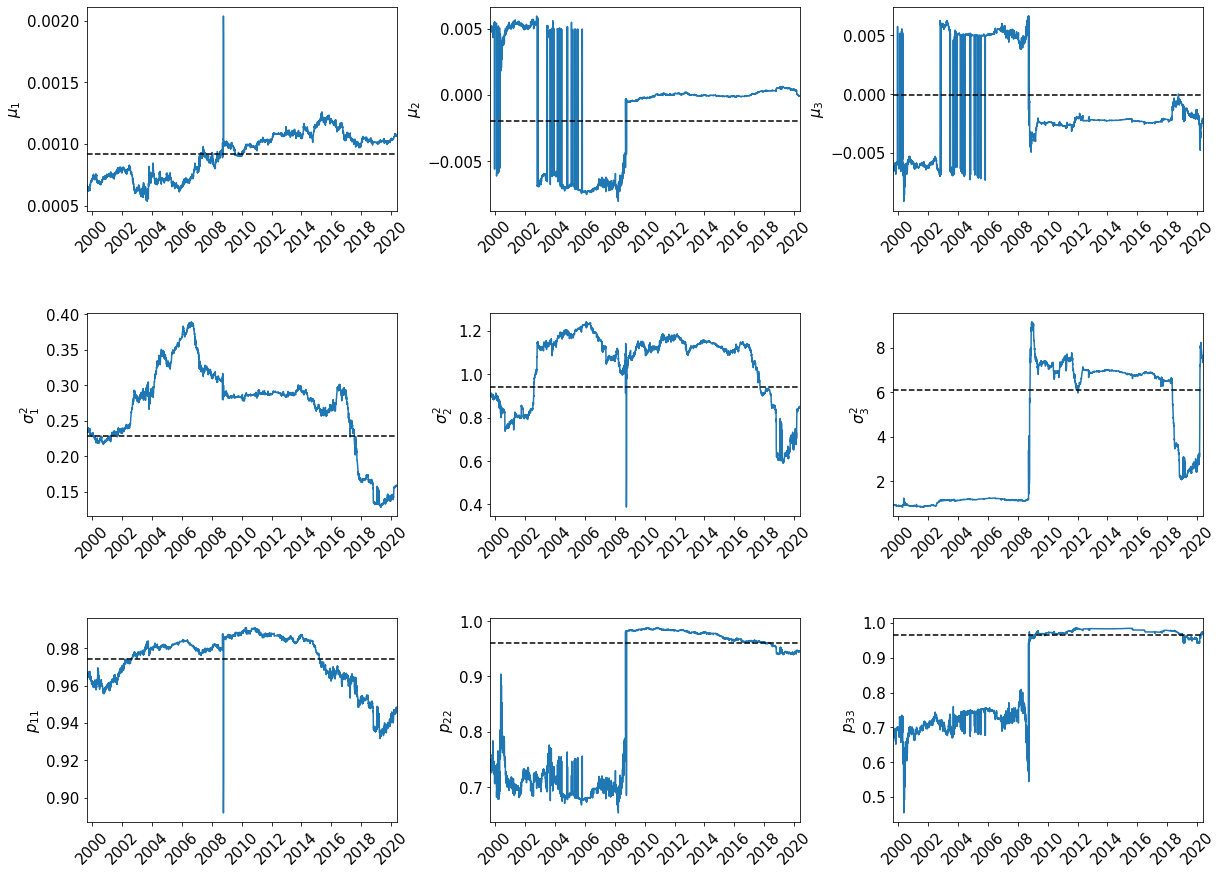

In [ ]:
# Create a 2x2 grid to plot in:
fig, ax = plt.subplots(3,3, figsize=(20,15), )
plt.subplots_adjust(wspace = 0.3, hspace=0.5)

ax1 = plt.subplot2grid((3,3), (0,0))
ax2 = plt.subplot2grid((3,3), (0,1))
ax3 = plt.subplot2grid((3,3), (0,2))
ax4 = plt.subplot2grid((3,3), (1,0))
ax5 = plt.subplot2grid((3,3), (1,1))
ax6 = plt.subplot2grid((3,3), (1,2))
ax7 = plt.subplot2grid((3,3), (2,0))
ax8 = plt.subplot2grid((3,3), (2,1))
ax9 = plt.subplot2grid((3,3), (2,2))

means_0_ = np.array(means_0)
means_1_ = np.array(means_1)
means_2_ = np.array(means_2)

var_0_ = np.array(var_0)
var_1_ = np.array(var_1)
var_2_ = np.array(var_2)

#Plotting
axes = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9]
variables = [means_0_, means_1_, means_2_,
             var_0_, var_1_, var_2_,
             trans_0_list, trans_1_list, trans_2_list]

symbol_list = ['$\mu_1$', '$\mu_2$', '$\mu_3$',
               '$\sigma^2_1$','$\sigma^2_2$', '$\sigma^2_3$',
               "$p_{11}$", "$p_{22}$", "$p_{33}$"]

static_var = [means_0_fix[0] / 10000, means_0_fix[1] / 10000, means_0_fix[2] / 10000,
              var_0_fix[0] / 10000, var_0_fix[2]  / 10000, var_0_fix[1]  / 10000,
             static_transmat[0,0], static_transmat[1,1], static_transmat[2,2]  ]

x_axis = df_rolling.index

for (ax,var,static_var, symbol) in zip(axes, variables, static_var, symbol_list):
    ax.plot(x_axis, var)
    ax.set_ylabel(symbol, size=15)
    ax.set_xlim(df_rolling.index[0], end_test_dt)
    ax.tick_params('x', labelrotation=45)   
    ax.axhline(y = static_var, ls="--", color = "black")

plt.savefig("3-state HMM rolling params")

In [ ]:
model.means_

array([[ 0.0727],
       [-0.2352],
       [-0.037 ]])

# Merge In-sample & Out-of-Sample predictions

In [ ]:
df_merged = df_rolling.copy()

df_merged[["MSCI ACWI", "log returns"] ] = \
                                        df.loc[df_rolling.index[0]:end_test, ["MSCI ACWI", "log returns"]]

df_merged.tail()

,states,Posterior prob 1,Posterior prob 2,Posterior prob 3,MSCI ACWI,log returns
Date,,,,,,
2020-05-13,2,2.1804e-06,0.5259,0.4741,3539.6198,-0.0176
2020-05-14,1,8.6155e-02,0.7263,0.1876,3543.0637,0.0010
2020-05-15,1,2.1995e-01,0.7149,0.0651,3558.6321,0.0044
2020-05-18,2,6.1618e-12,0.0972,0.9028,3666.5821,0.0299
2020-05-19,2,1.3610e-02,0.2726,0.7138,3653.4373,-0.0036


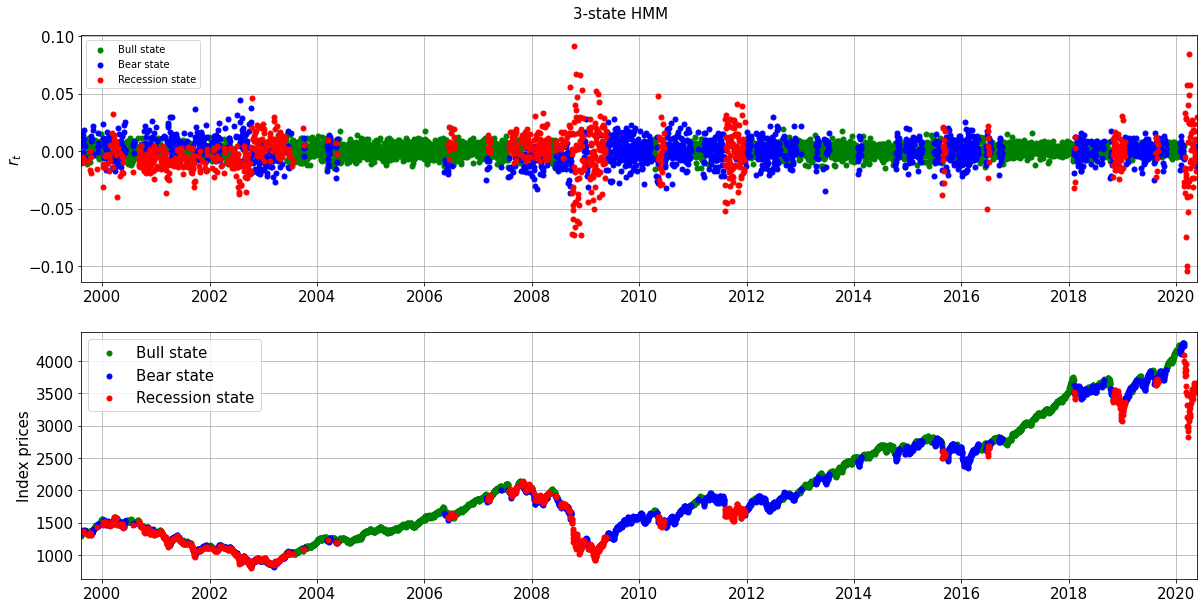

In [ ]:
figsize = (20,10)

# 2X1 Grid
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize )

colors = ["green", "blue", "red"] #"purple"]
variables = ["log returns", "MSCI ACWI"]
ylabels = ["$r_t$", "Index prices"]
fig.suptitle('3-state HMM', y = 0.92)

for (ax, var, ylabel) in zip([ax1,ax2], variables, ylabels):
    
    n_states = max(df_merged["states"].unique()+1) # Number of states in current iteration
    if n_states == 2: labels = ["Bull state", "Bear state"]
    elif n_states == 3: labels = ["Bull state", "Bear state", "Recession state"]
    
    for state,color,label in zip(df_merged["states"].unique(), colors, labels ):
        plot_area = df_merged[df_merged["states"] == state]
        ax.scatter(plot_area.index , plot_area[var],
                    label=label, color=color,
                    s = 25,
                   zorder = 2)

    ax.set_xlim(df_rolling.index[0], end_test_dt )
    ax.set_ylabel(ylabel)
    if ax == ax1: ax.legend(fontsize=10)
    else: ax.legend()
    ax.grid(True, ls="-")

plt.savefig("3-state ts")

# Probability Smoothing

In [ ]:
confidence_treshold = 0.92
            
df_merged["states_filtered"] = 5
df_merged["states_filtered"].iloc[0] = df_merged["states"].iloc[0]

for i in range(1,len(df_merged)):
    row = df_merged.iloc[i]
    
    last_pred = df_merged["states_filtered"].iloc[i-1]
    
    if row["states"] == last_pred:
        df_merged["states_filtered"].iloc[i] = row["states"]
        
    elif row["states"] == 0:
        if row["Posterior prob 1"] > confidence_treshold:
            df_merged["states_filtered"].iloc[i] = 0
        else:
            df_merged["states_filtered"].iloc[i] = last_pred

    elif row["states"] == 1:
        if row["Posterior prob 2"] > confidence_treshold:
            df_merged["states_filtered"].iloc[i] = 1
        else:
            df_merged["states_filtered"].iloc[i] = last_pred
            
    elif row["states"] == 2:
        if row["Posterior prob 3"] > confidence_treshold:
            df_merged["states_filtered"].iloc[i] = 2
        else:
            df_merged["states_filtered"].iloc[i] = last_pred

if df_merged[df_merged["states_filtered"] == 5]["states_filtered"].count() != 0:
    print("ERROR IN PROBABILITY FILTER")

In [ ]:
# function to indicate if there is a transition
def transition_counter(x):
    # is a dataframe with two columns: (1) current state and (2) previous state for each period
    if x[0] == x[1]:
        return 0
    else:
        return 1

df_merged['previous state'] = df_merged['states'].shift(1)
df_merged["previous state"].iloc[0] = df_merged["states"].iloc[0] #Otherwise first row is NaN

print("Number of transitions before smoothing = ", df_merged[['previous state', 'states']].apply(transition_counter, axis = 1).sum())

df_merged['previous state filtered'] = df_merged['states_filtered'].shift(1)
df_merged["previous state filtered"].iloc[0] = df_merged["states_filtered"].iloc[0] #Otherwise first row is NaN

print("Number of transitions after smoothing = ", df_merged[['previous state filtered', 'states_filtered']].apply(transition_counter, axis = 1).sum())

Number of transitions before smoothing =  573
Number of transitions after smoothing =  122


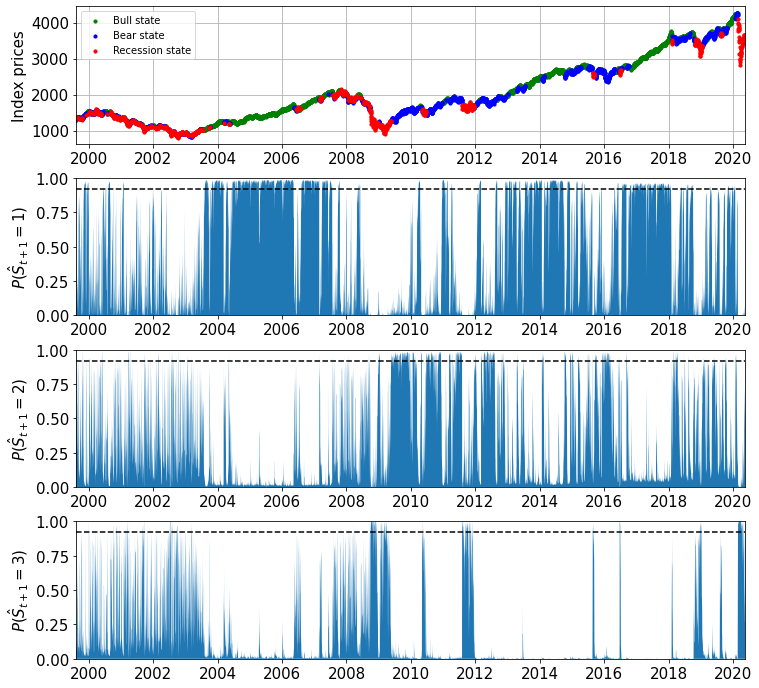

In [ ]:
# Create a 2x2 grid to plot in:
fig, (ax1, ax2,ax3, ax4) = plt.subplots(4,1, figsize=(12,12))
plt.subplots_adjust(wspace = 0, hspace=0.25)

for state,color,label in zip(df_merged["states"].unique(), colors, labels ):
    
    plot_area = df_merged[df_merged["states"] == state]
    ax1.scatter(plot_area.index , plot_area["MSCI ACWI"],
                label=label, color=color,
                s = 10,
               zorder = 2)

ax1.set_xlim(df_merged.index[0], df_merged.index[-1])
ax1.set_ylabel("Index prices")
ax1.grid(True, ls="-")
ax1.legend(fontsize=10)

ax2.fill_between(df_merged.index, df_merged['Posterior prob 1'])
ax2.hlines(confidence_treshold, min(df_merged.index), max(df_merged.index), color = 'black', linestyles = '--')
ax2.set_ylabel("$P(\hat{S}_{t + 1} = 1)$", size=15)
ax2.set_xlim(df_merged.index[0], df_merged.index[-1])
ax2.set_ylim(0, 1)

ax3.fill_between(df_merged.index, df_merged['Posterior prob 2'])
ax3.hlines(confidence_treshold, min(df_merged.index), max(df_merged.index), color = 'black', linestyles = '--')
ax3.set_ylabel("$P(\hat{S}_{t + 1} = 2)$", size=15)
ax3.set_xlim(df_merged.index[0], df_merged.index[-1])
ax3.set_ylim(0, 1)

ax4.fill_between(df_merged.index, df_merged['Posterior prob 3'])
ax4.hlines(confidence_treshold, min(df_merged.index), max(df_merged.index), color = 'black', linestyles = '--')
ax4.set_ylabel("$P(\hat{S}_{t + 1} = 3)$", size=15)
ax4.set_xlim(df_merged.index[0], df_merged.index[-1])
ax4.set_ylim(0, 1)

plt.savefig("3-state Prob_filter")

### Output to CSV

In [ ]:
df_merged[["states", "MSCI ACWI", "log returns"]].to_csv("3-state predictions.csv")

(0.0, 0.4201186621316712)

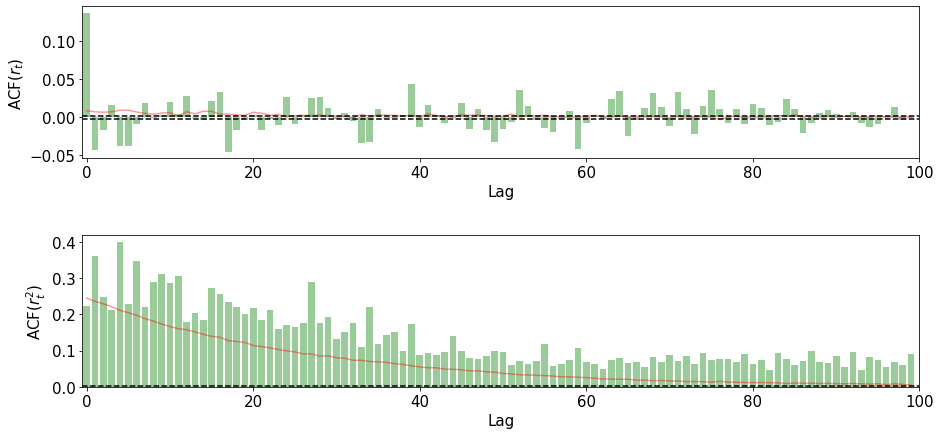

In [ ]:
n_lags = 100
static_samples_n = 1000000
static_samples = model.sample(static_samples_n)[0]

#### Compute ACF and ACF^2 for static model
lags = [i for i in range(n_lags)]
acf_1 = sm.tsa.acf(static_samples, nlags=n_lags)[1:]
acf_squared_1 = sm.tsa.acf(static_samples**2, nlags=n_lags)[1:]

acf_2 = sm.tsa.acf(x_train, nlags=n_lags)[1:]
acf_squared_2 = sm.tsa.acf(x_train**2, nlags=n_lags)[1:]

acf_conf = [1.96 / np.sqrt(len(static_samples)), -1.96 / np.sqrt(len(static_samples))]
acf_squared_conf = [1.96 / np.sqrt(len(static_samples**2)), -1.96 / np.sqrt(len(static_samples**2))]

# Create a 2x1 grid to plot in:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(15,7))
plt.subplots_adjust(wspace = 0.2, hspace=0.5)

#Plot ACF & PACF
labels = ["ACF($r_t)$","ACF($r^2_t$)"]
variables_1 = [acf_1, acf_squared_1]
variables_2 = [acf_2, acf_squared_2]
confidence = [acf_conf, acf_squared_conf]
for (ax, var, var2, conf, label) in zip([ax1, ax2], variables_1, variables_2, confidence, labels):
    ax.plot(lags, var, color="red", alpha=0.4, label = "In-sample log returns ACF")
    ax.bar(lags, var2, color="g", alpha=0.4, label = "Static 2-state HMM ACF")
    ax.axhline(conf[0], linestyle = 'dashed', color = 'black')
    ax.axhline(conf[1], linestyle = 'dashed', color = 'black')
    ax.set_ylabel(label)
    ax.set_xlabel("Lag")
    ax.set_xlim(left=-0.5, right = max(lags)+1)
    
ax2.set_ylim(bottom=0)